# Setup

In [1]:
# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

# check environment
import os
print(f'Conda Environment: ' + os.environ['CONDA_DEFAULT_ENV'])

from platform import python_version
print(f'python version: {python_version()}')

Conda Environment: ROICaT
python version: 3.9.13


In [2]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import natsort

import torch

import gc
import time
import functools
import multiprocessing as mp


In [3]:
tic = time.time()
toc = {}
toc['start'] = time.time() - tic

In [4]:
%load_ext autoreload
%autoreload 2
import roicat
# from roicat import helpers, data_importing, ROInet
# from roicat.tracking import alignment, blurring, clustering, scatteringWaveletTransformer, similarity_graph, visualization

In [5]:
from bnpm import file_helpers

In [6]:
%matplotlib notebook

# Import paths

In [7]:
# dir_allOuterFolders = Path(r"/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp16").resolve()
# dir_allOuterFolders = Path(r"/media/rich/bigSSD/res2p/scanimage data/round 5 experiments/mouse 2_6/just_stat_files").resolve()
# dir_allOuterFolders = str(Path(r"/media/rich/bigSSD/other lab data/Harvey_lab_ROIs/Sofia_ROIs/Data for Rich/SS33/").resolve())
# dir_allOuterFolders = str(Path(r"/media/rich/bigSSD/downloads_tmp/tmp_data/mouse_1511L/statFiles/").resolve())
# dir_allOuterFolders = str(Path(r"/media/rich/bigSSD/downloads_tmp/tmp_data/mouse_g8test/").resolve())
# dir_allOuterFolders = str(Path(r"/home/rich/Downloads/NN11/").resolve())
dir_allOuterFolders = str(Path(r"/media/rich/bigSSD/downloads_tmp/NN9").resolve())

# folders_allSessions = natsort.natsorted(helpers.get_dir_contents(dir_allOuterFolders)[0])[:]

# dir_allS2pFolders = [dir_allOuterFolders / folder for folder in folders_allSessions]

pathSuffixToStat = 'stat.npy'
pathSuffixToOps = 'ops.npy'
# pathSuffixToStat = 'Slice02/stat.npy'
# pathSuffixToOps = 'Slice02/ops.npy'

# paths_allStat = np.array([path / pathSuffixToStat for path in dir_allS2pFolders])[:]
paths_allStat = test = roicat.helpers.find_paths(
    dir_outer=dir_allOuterFolders,
    reMatch=pathSuffixToStat,
    depth=4,
)[:]
# paths_allOps  = np.array([path / pathSuffixToOps for path in dir_allS2pFolders])[:]
paths_allOps = test = roicat.helpers.find_paths(
    dir_outer=dir_allOuterFolders,
    reMatch=pathSuffixToOps,
    depth=4,
)[:]
# paths_allStat = np.array([path / pathSuffixToStat for path in dir_allS2pFolders])
# paths_allOps  = np.array([path / pathSuffixToOps for path in dir_allS2pFolders])

# print(f'folder names of all sessions: \n{display(folders_allSessions)}')
print(f'paths to all stat files:');
[print(path) for path in paths_allStat];
print('');
print(f'paths to all ops files:');
[print(path) for path in paths_allOps];


paths to all stat files:
/media/rich/bigSSD/downloads_tmp/NN9/210428/stat.npy
/media/rich/bigSSD/downloads_tmp/NN9/210429/stat.npy
/media/rich/bigSSD/downloads_tmp/NN9/210501/stat.npy
/media/rich/bigSSD/downloads_tmp/NN9/210502/stat.npy
/media/rich/bigSSD/downloads_tmp/NN9/210503/stat.npy
/media/rich/bigSSD/downloads_tmp/NN9/210505/stat.npy
/media/rich/bigSSD/downloads_tmp/NN9/210506/stat.npy
/media/rich/bigSSD/downloads_tmp/NN9/210507/stat.npy
/media/rich/bigSSD/downloads_tmp/NN9/210509/stat.npy
/media/rich/bigSSD/downloads_tmp/NN9/210510/stat.npy
/media/rich/bigSSD/downloads_tmp/NN9/210511/stat.npy
/media/rich/bigSSD/downloads_tmp/NN9/210512/stat.npy
/media/rich/bigSSD/downloads_tmp/NN9/210513/stat.npy
/media/rich/bigSSD/downloads_tmp/NN9/210514/stat.npy

paths to all ops files:
/media/rich/bigSSD/downloads_tmp/NN9/210428/ops.npy
/media/rich/bigSSD/downloads_tmp/NN9/210429/ops.npy
/media/rich/bigSSD/downloads_tmp/NN9/210501/ops.npy
/media/rich/bigSSD/downloads_tmp/NN9/210502/ops.npy


In [8]:
paths_allStat

['/media/rich/bigSSD/downloads_tmp/NN9/210428/stat.npy',
 '/media/rich/bigSSD/downloads_tmp/NN9/210429/stat.npy',
 '/media/rich/bigSSD/downloads_tmp/NN9/210501/stat.npy',
 '/media/rich/bigSSD/downloads_tmp/NN9/210502/stat.npy',
 '/media/rich/bigSSD/downloads_tmp/NN9/210503/stat.npy',
 '/media/rich/bigSSD/downloads_tmp/NN9/210505/stat.npy',
 '/media/rich/bigSSD/downloads_tmp/NN9/210506/stat.npy',
 '/media/rich/bigSSD/downloads_tmp/NN9/210507/stat.npy',
 '/media/rich/bigSSD/downloads_tmp/NN9/210509/stat.npy',
 '/media/rich/bigSSD/downloads_tmp/NN9/210510/stat.npy',
 '/media/rich/bigSSD/downloads_tmp/NN9/210511/stat.npy',
 '/media/rich/bigSSD/downloads_tmp/NN9/210512/stat.npy',
 '/media/rich/bigSSD/downloads_tmp/NN9/210513/stat.npy',
 '/media/rich/bigSSD/downloads_tmp/NN9/210514/stat.npy']

In [9]:
toc['import_paths'] = time.time() - tic

# Import data

In [10]:
toc['import_data'] = time.time() - tic

In [320]:
FOVs_mixed = [f + 10*sf.sum(0).reshape(data.FOV_height, data.FOV_width) for f, sf in zip(data.FOV_images, data.spatialFootprints)]

data = roicat.data_importing.Data_suite2p(
    paths_statFiles=paths_allStat[:],
#     paths_opsFiles=paths_allOps[:],
    um_per_pixel=4.0,
    new_or_old_suite2p='new',

    out_height_width=[36,36],
    
#     type_meanImg='meanImgE',
    FOV_images=FOVs_mixed,

    verbose=True,
)

assert data.check_completeness(verbose=False)['tracking'], f"Data object is missing attributes necessary for tracking."

Completed: Set FOV_images for 14 sessions successfully.
Importing spatial footprints from stat files.


100%|███████████████████████████████████████████| 14/14 [00:16<00:00,  1.18s/it]


Imported 14 sessions of spatial footprints into sparse arrays.
Completed: Set spatialFootprints for 14 sessions successfully.
Completed: Created sessionID_concat.
Completed: Created centroids.
Staring: Creating centered ROI images from spatial footprints...
Completed: Created ROI images.


<IPython.core.display.Javascript object>


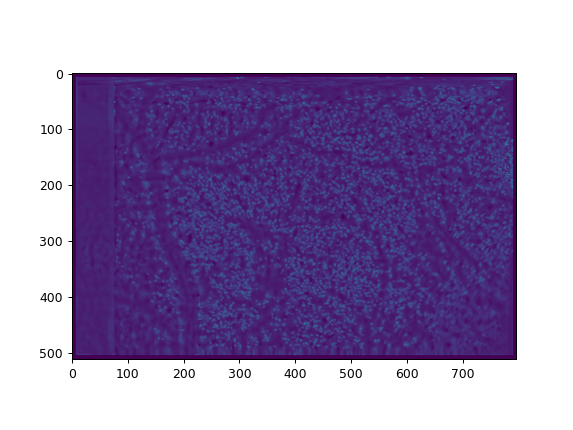

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

<IPython.core.display.Javascript object>


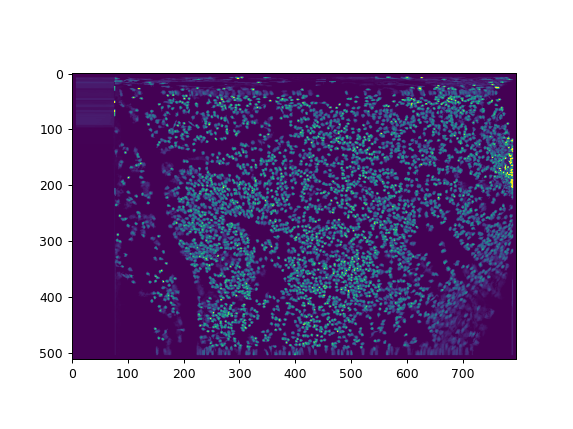

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

<IPython.core.display.Javascript object>


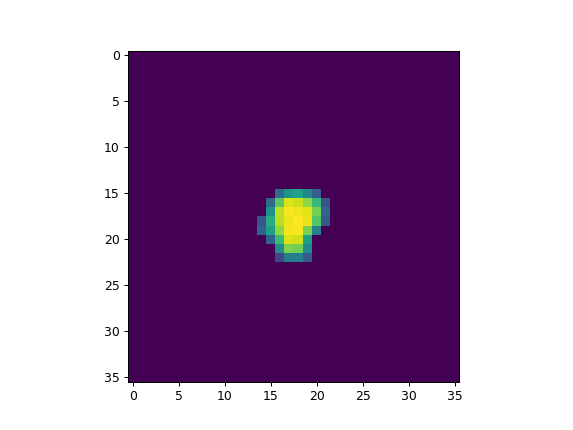

interactive(children=(IntSlider(value=0, description='i_frame', max=60834), Output()), _dom_classes=('widget-i…

In [91]:
%matplotlib notebook

roicat.visualization.display_toggle_image_stack(data.FOV_images)

roicat.visualization.display_toggle_image_stack([sf.max(0).reshape(data.FOV_height, data.FOV_width).toarray() for sf in data.spatialFootprints], clim=[0,0.1])

roicat.visualization.display_toggle_image_stack(np.concatenate(data.ROI_images, axis=0))

# Alignment

In [323]:
use_CLAHE = False
use_PCR = False

idx_session_template = 0.5
idx_st = int(idx_session_template * data.n_sessions) if type(idx_session_template) is float else idx_session_template

FOV_images = [roicat.tracking.alignment.clahe(im, grid_size=10, clipLimit=0, normalize=True) for im in data.FOV_images] if use_CLAHE else data.FOV_images

if use_PCR:
    pcr = roicat.tracking.alignment.PhaseCorrelation_registration()

    pcr.set_spectral_mask(
        freq_highPass=0.01,
        freq_lowPass=0.3,
        im_shape=(data.FOV_height, data.FOV_width),
    )

    pcr.register(
        template=FOV_images[idx_st],
        ims_moving=FOV_images,
        template_method='image',
    );

aligner = roicat.tracking.alignment.Alinger(
    method='createOptFlow_DeepFlow',
    kwargs_method=None,
)

In [324]:
aligner.register_ROIs(
    template=pcr.ims_registered[idx_st] if use_PCR else FOV_images[idx_st],
    FOVs=pcr.ims_registered if use_PCR else FOV_images,
    ROIs=data.spatialFootprints,
    template_method='image',
    shifts=pcr.shifts[:] if use_PCR else None,
    return_sparse=True,
    normalize=True,
);

Finding optical flow fields between FOVs using image template...


100%|███████████████████████████████████████████| 14/14 [00:06<00:00,  2.33it/s]


Registering ROIs...


100%|███████████████████████████████████████████| 14/14 [04:58<00:00, 21.29s/it]


<IPython.core.display.Javascript object>


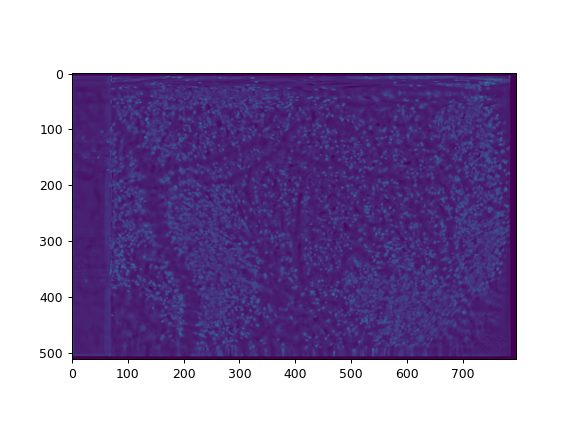

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

<IPython.core.display.Javascript object>


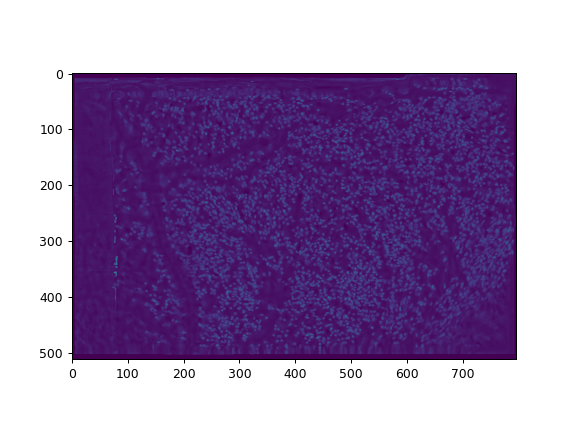

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

<IPython.core.display.Javascript object>


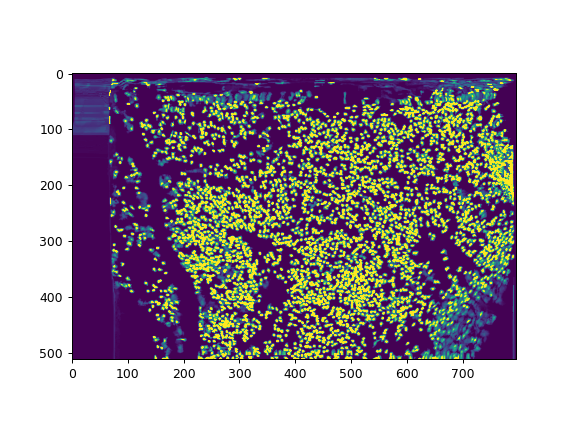

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

<IPython.core.display.Javascript object>


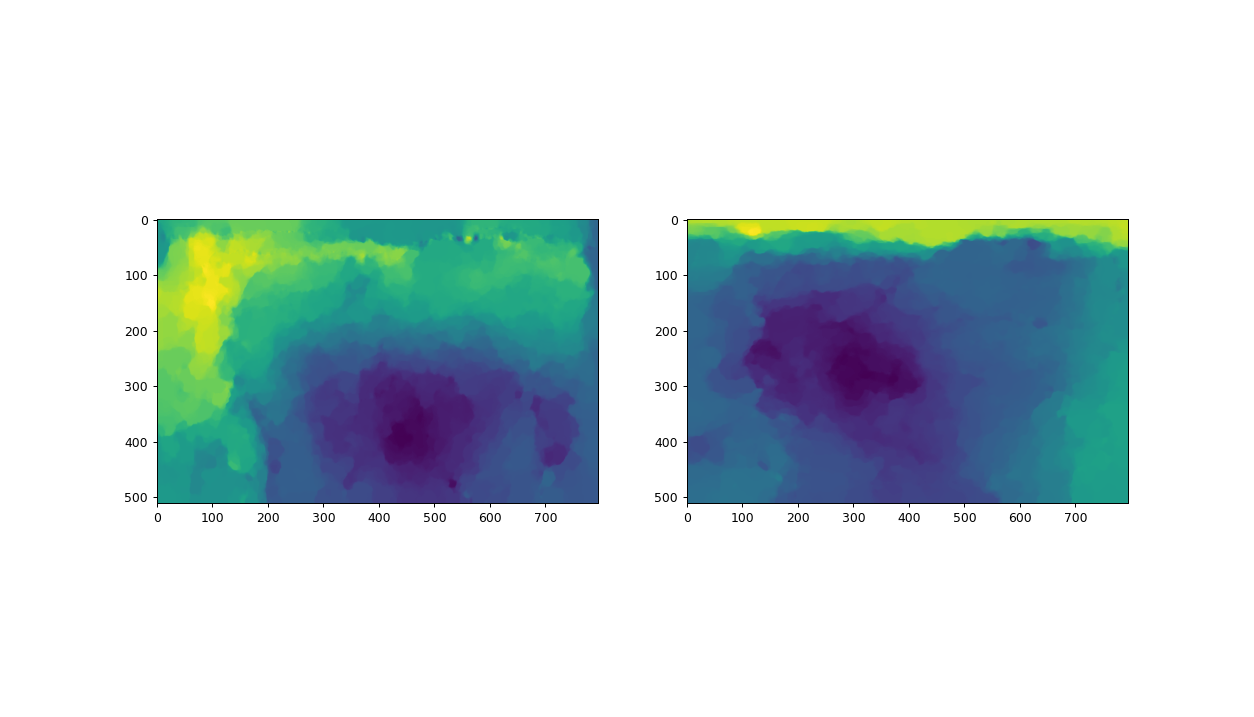

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

In [325]:
%matplotlib notebook

roicat.visualization.display_toggle_image_stack(pcr.ims_registered[:])

roicat.visualization.display_toggle_image_stack(aligner.FOVs_aligned)
roicat.visualization.display_toggle_image_stack(aligner.get_ROIsAligned_maxIntensityProjection(), clim=[0,0.03])
roicat.visualization.display_toggle_2channel_image_stack(aligner.flows)

In [326]:
toc['alignment'] = time.time() - tic

## Blur ROIs (optional)

In [327]:
blurrer = roicat.tracking.blurring.ROI_Blurrer(
    frame_shape=(data.FOV_height, data.FOV_width),
    kernel_halfWidth=2,
    plot_kernel=False,
)

blurrer.blur_ROIs(
    spatialFootprints=aligner.ROIs_aligned[:],
)

Preparing the Toeplitz convolution matrix
Performing convolution for blurring


<IPython.core.display.Javascript object>


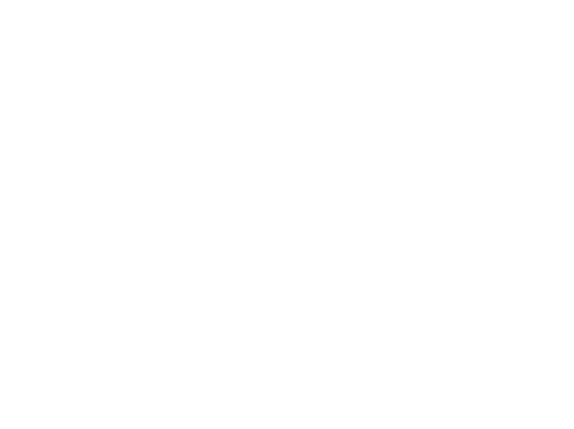

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

In [328]:
%matplotlib notebook
roicat.visualization.display_toggle_image_stack(blurrer.get_ROIsBlurred_maxIntensityProjection())

In [329]:
toc['blur'] = time.time() - tic

## Neural network embedding distances

In [330]:
roinet = roicat.ROInet.ROInet_embedder(
    device='cuda:0',
    dir_networkFiles=r'/home/rich/Desktop/tmp_data/',
    download_method='check_local_first',
    download_url='https://osf.io/x3fd2/download',
    download_hash='7a5fb8ad94b110037785a46b9463ea94',
    forward_pass_version='latent',
    verbose=True,
)

File already exists locally: /home/rich/Desktop/tmp_data/ROInet.zip
Hash of local file matches provided hash_hex.
Extracting /home/rich/Desktop/tmp_data/ROInet.zip to /home/rich/Desktop/tmp_data.
Completed zip extraction.
['/home/rich/Desktop/tmp_data/ROInet_tracking_20220527', '/home/rich/Desktop/tmp_data/ROInet_tracking_20220527/params.json', '/home/rich/Desktop/tmp_data/ROInet_tracking_20220527/ReadMe.txt', '/home/rich/Desktop/tmp_data/ROInet_tracking_20220527/model.py', '/home/rich/Desktop/tmp_data/ROInet_tracking_20220527/ConvNext_tiny__1_0_best__simCLR.pth']
Imported model from /home/rich/Desktop/tmp_data/ROInet_tracking_20220527/model.py
Loaded params_model from /home/rich/Desktop/tmp_data/ROInet_tracking_20220527/params.json


/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/ROICaT/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/ROICaT/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Generated network using params_model
Loaded state_dict into network from /home/rich/Desktop/tmp_data/ROInet_tracking_20220527/ConvNext_tiny__1_0_best__simCLR.pth
Loaded network onto device cuda:0


In [331]:
roinet.generate_dataloader(
    ROI_images=data.ROI_images,
    um_per_pixel=data.um_per_pixel,
    pref_plot=False,
    
    jit_script_transforms=True,
    
    batchSize_dataloader=8,
    pinMemory_dataloader=True,
    numWorkers_dataloader=mp.cpu_count(),
    persistentWorkers_dataloader=True,
    prefetchFactor_dataloader=2,    

#     batchSize_dataloader=1,
#     pinMemory_dataloader=False,
#     numWorkers_dataloader=0,
#     persistentWorkers_dataloader=False,
#     prefetchFactor_dataloader=2,    
);

Starting: resizing ROIs
Completed: resizing ROIs
Defined image transformations: Sequential(
  (0): ScaleDynamicRange(scaler_bounds=(0, 1))
  (1): Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
  (2): TileChannels(dim=0)
)
Defined dataset
Defined dataloader


/media/rich/Home_Linux_partition/github_repos/ROICaT/roicat/ROInet.py:325: UserWarning: 


  warnings.warn("\n\nWarning: Converting transforms to a jit-based script has been known to cause issues on Windows when numWorkers_dataloader > 0. If self.generate_latents() raises an Exception similar to 'Tried to serialize object __torch__.torch.nn.modules.container.Sequential which does not have a __getstate__ method defined!' consider setting numWorkers_dataloader=0 or jit_script_transforms=False.\n")


<IPython.core.display.Javascript object>


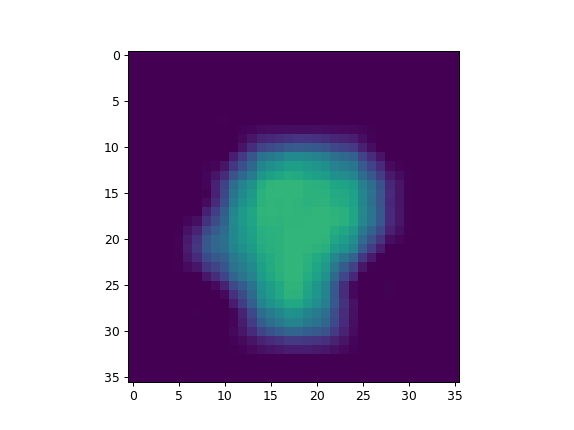

interactive(children=(IntSlider(value=0, description='i_frame', max=60834), Output()), _dom_classes=('widget-i…

In [332]:
%matplotlib notebook
roicat.visualization.display_toggle_image_stack(roinet.ROI_images_rs, clim=[0, 0.05])

In [333]:
roinet.generate_latents();


starting: running data through network


  0%|                                                  | 0/7605 [00:00<?, ?it/s]/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/ROICaT/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %247 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/ROICaT/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %247 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/ROICaT/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %247 : int =

/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/ROICaT/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %247 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/ROICaT/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %247 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/ROICaT/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %247 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggere

completed: running data through network


In [334]:
gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()

In [335]:
toc['NN'] = time.time() - tic

## Scattering wavelet embedding distances

In [336]:
swt = roicat.tracking.scatteringWaveletTransformer.SWT(
    kwargs_Scattering2D={'J': 2, 'L': 2}, 
    image_shape=data.ROI_images[0].shape[1:3], 
    device='cuda:0'
)

swt.transform(
    ROI_images=np.concatenate(data.ROI_images, axis=0),
    batch_size=100,
);

SWT initialized
Starting: SWT transform on ROIs


609it [00:01, 360.52it/s]                                                       

Completed: SWT transform on ROIs


In [337]:
gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()


In [338]:
toc['SWT'] = time.time() - tic

## Compute similarities

<IPython.core.display.Javascript object>


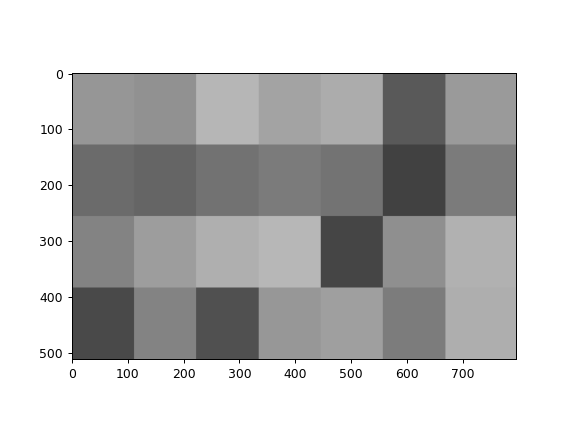

Computing pairwise similarity between ROIs...


100%|███████████████████████████████████████████| 28/28 [00:29<00:00,  1.04s/it]


Joining blocks into full similarity matrices...
Joining s_sf...


37009it [00:34, 1065.17it/s]                                                    


Joining s_NN...


37009it [00:35, 1053.96it/s]                                                    


Joining s_SWT...


37009it [00:36, 1027.56it/s]                                                    


Joining s_sesh...


37009it [00:34, 1062.46it/s]                                                    


In [339]:
sim = roicat.tracking.similarity_graph.ROI_graph(
    n_workers=-1,
    frame_height=data.FOV_height,
    frame_width=data.FOV_width,
#     block_height=data.FOV_height,
#     block_width=data.FOV_width,
    block_height=128,
    block_width=128,
    algorithm_nearestNeigbors_spatialFootprints='brute',
    verbose=True,
)

sim.visualize_blocks()

s_sf, s_NN, s_SWT, s_sesh = sim.compute_similarity_blockwise(
    spatialFootprints=blurrer.ROIs_blurred,
#     spatialFootprints=aligner.ROIs_aligned,
    features_NN=roinet.latents,
    features_SWT=swt.latents,
    ROI_session_bool=data.sessionID_concat,
    spatialFootprint_maskPower=1.0,
);

In [340]:
sim.make_normalized_similarities(
    centers_of_mass=data.centroids,
    features_NN=roinet.latents,
    features_SWT=swt.latents,
#     features_SWT=None,
    k_max=4000,
    k_min=100,
    algo_NN='kd_tree',
    device='cuda:0'
)

toc['sim'] = time.time() - tic

Finding k-range of center of mass distance neighbors for each ROI...
Normalizing Neural Network similarity scores...


100%|██████████████████████████████████| 60835/60835 [00:04<00:00, 13908.27it/s]


Normalizing SWT similarity scores...


100%|██████████████████████████████████| 60835/60835 [00:05<00:00, 10906.80it/s]


# Clustering

In [341]:
clusterer = roicat.tracking.clustering.Clusterer(
    s_sf=sim.s_sf,
    s_NN_z=sim.s_NN_z,
    s_SWT_z=sim.s_SWT_z,
    s_sesh=sim.s_sesh,
)

kwargs_makeConjunctiveDistanceMatrix_best = clusterer.find_optimal_parameters_for_pruning(
    n_bins=50,
    find_parameters_automatically=True,
    kwargs_findParameters={
        'n_patience': 100,
        'tol_frac': 0.05,
        'max_trials': 350,
        'max_duration': 60*10,
        'verbose': False,
    },
    bounds_findParameters={
        'power_SF': (0.3, 2),
        'power_NN': (0.2, 2),
        'power_SWT': (0.1, 1),
        'p_norm': (-5, 5),
        'sig_NN_kwargs_mu': (0, 0.5),
        'sig_NN_kwargs_b': (0.05, 2),
        'sig_SWT_kwargs_mu': (0, 0.5),
        'sig_SWT_kwargs_b': (0.05, 2),
    },
    n_jobs_findParameters=-1,    
#     fallback_d_cutoff=0.5,
#     plot_pref=True,
)

toc['separate_diffSame'] = time.time() - tic

Finding mixing parameters using automated hyperparameter tuning...
Best value found: 0.10075546056032181 with parameters {'power_SF': 1.5860017834719442, 'power_NN': 0.3623853677960458, 'power_SWT': 0.3871462699686379, 'p_norm': -3.52431423437676, 'sig_SF_kwargs': None, 'sig_NN_kwargs': {'mu': 0.2929266847938706, 'b': 0.3581660889906379}, 'sig_SWT_kwargs': {'mu': 0.31826899075773113, 'b': 0.3651049255495231}}


<IPython.core.display.Javascript object>


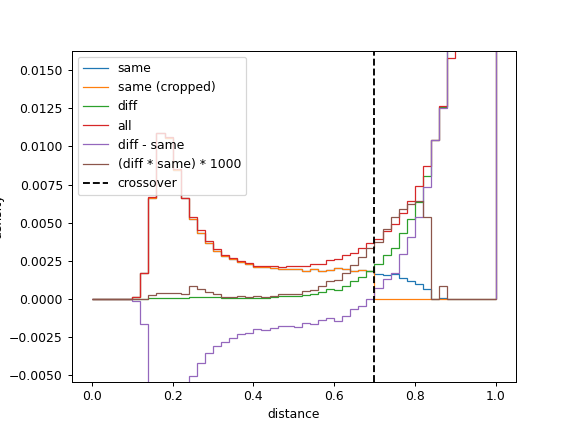

<IPython.core.display.Javascript object>


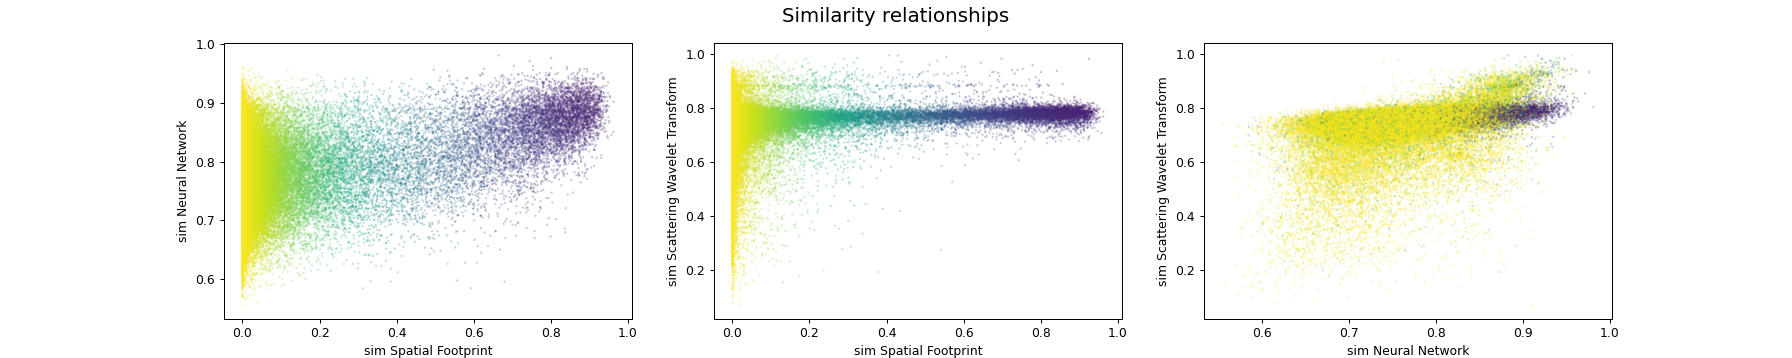

In [342]:
clusterer.plot_distSame()

clusterer.plot_similarity_relationships(
    plots_to_show=[1,2,3], 
    max_samples=100000, 
    kwargs_scatter={'s':1, 'alpha':0.2},
    kwargs_makeConjunctiveDistanceMatrix=kwargs_makeConjunctiveDistanceMatrix_best,
#     kwargs_makeConjunctiveDistanceMatrix={
#         'power_SF': 1.0,
#         'power_NN': 1.0,
#         'power_SWT': 0.1,
#         'p_norm': -4.0,
#         'sig_SF_kwargs': {'mu':0.5, 'b':4},
# #         'sig_SF_kwargs': None,
#         'sig_NN_kwargs': {'mu':0.5, 'b':1.5},
#         'sig_SWT_kwargs': {'mu':0.5, 'b':0.5},
#     },
);

In [343]:
clusterer.make_pruned_similarity_graphs(
    d_cutoff=None,
    kwargs_makeConjunctiveDistanceMatrix=kwargs_makeConjunctiveDistanceMatrix_best,
    stringency=0.6,
)

/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/ROICaT/lib/python3.9/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [47]:
if data.n_sessions >= 8:
    labels = clusterer.fit(
        session_bool=data.sessionID_concat,
        min_cluster_size=2,
        cluster_selection_method='leaf',
        d_clusterMerge=None,
        alpha=0.999,
        n_iter_violationCorrection=6,
        d_conj=None,
        kwargs_makeConjunctiveDistanceMatrix=kwargs_makeConjunctiveDistanceMatrix_best,
    #     kwargs_makeConjunctiveDistanceMatrix={
    #         'power_SF': 1.0,
    #         'power_NN': 1.0,
    #         'power_SWT': 0.1,
    #         'p_norm': -2,
    #         'sig_SF_kwargs': None,
    #         'sig_NN_kwargs':  {'mu':0, 'b':0.2},
    #         'sig_SWT_kwargs': {'mu':0, 'b':0.2},
    #     },
        split_intraSession_clusters=True,
        discard_failed_pruning=True,
        d_step=0.01,
    )

else:
    labels = clusterer.fit_sequentialHungarian(
        session_bool=data.sessionID_concat,
        thresh_cost=0.6,
        d_conj=None,
        kwargs_makeConjunctiveDistanceMatrix=kwargs_makeConjunctiveDistanceMatrix_best,
    #     kwargs_makeConjunctiveDistanceMatrix={
    #     'power_SF': 1.0,
    #     'power_NN': 1.0,
    #     'power_SWT': 0.1,
    #     'p_norm': -2,
    #     'sig_SF_kwargs': None,
    #     'sig_NN_kwargs':  {'mu':0, 'b':0.2},
    #     'sig_SWT_kwargs': {'mu':0, 'b':0.2},
    #     },
    )

labels_bySession = [labels[idx] for idx in data.sessionID_concat.T]

Fitting with HDBSCAN and splitting clusters with multiple ROIs per session


100%|████████████████████████████████████████████| 6/6 [10:28<00:00, 104.72s/it]


In [54]:
## results_clustering
print(f'Number of clusters: {len(np.unique(labels))}')
print(f'Number of discarded ROIs: {(labels==-1).sum()}')

Number of clusters: 7956
Number of discarded ROIs: 10185


In [49]:
toc['clustering'] = time.time() - tic

# Visualize results

In [50]:
FOV_clusters = roicat.visualization.compute_colored_FOV(
    spatialFootprints=[r.power(0.7) for r in aligner.ROIs_aligned],
    FOV_height=data.FOV_height,
    FOV_width=data.FOV_width,
    boolSessionID=data.sessionID_concat,
    labels=labels,
    confidence=None,
)

<IPython.core.display.Javascript object>


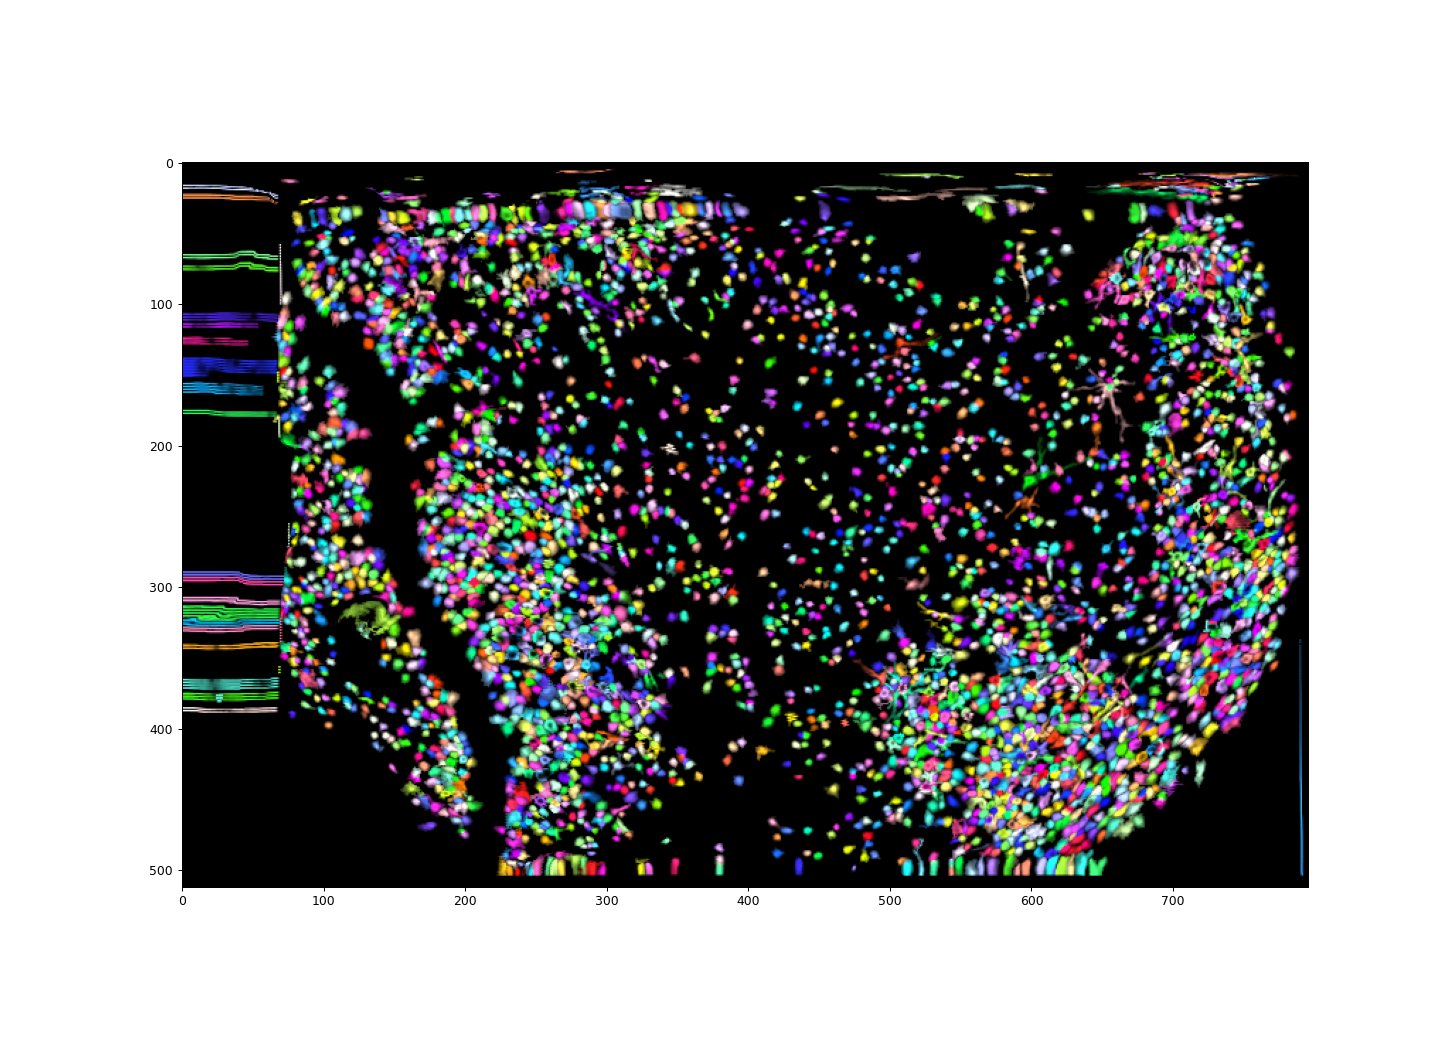

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

In [57]:
%matplotlib notebook
roicat.visualization.display_toggle_image_stack(
    FOV_clusters, 
#     interpolation='none', 
#     filternorm=False, 
#     resample=False
)

In [52]:
# visualization.display_toggle_image_stack(aligner.get_ROIsAligned_maxIntensityProjection())

/tmp/ipykernel_1628621/3423584665.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(40,1))


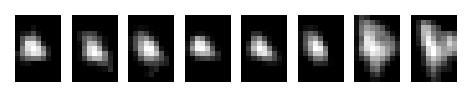

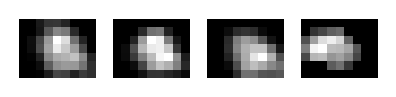

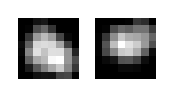

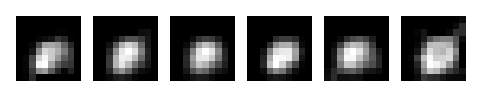

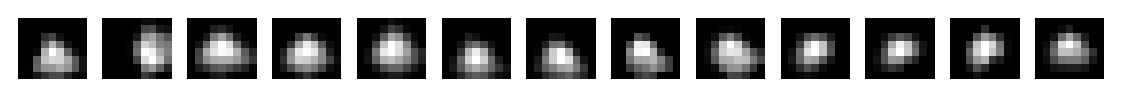

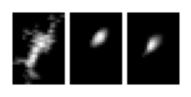

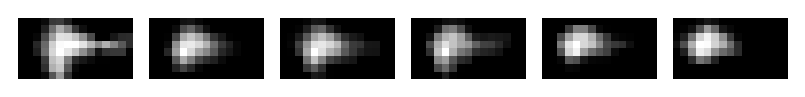

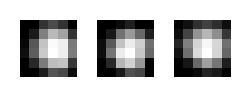

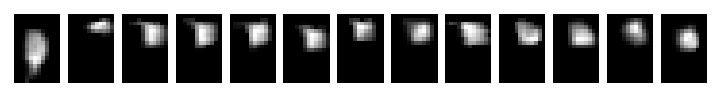

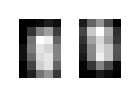

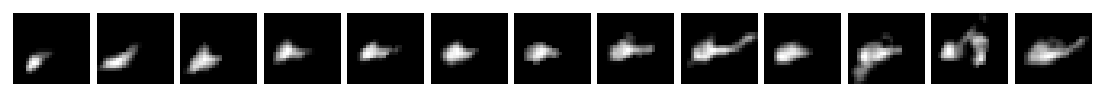

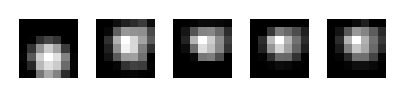

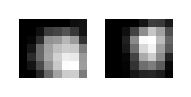

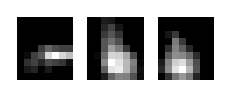

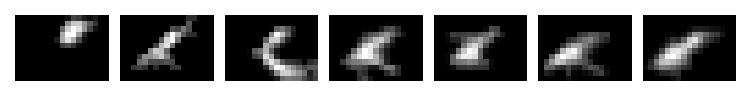

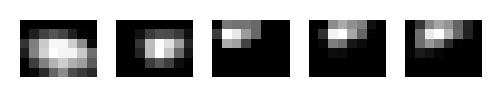

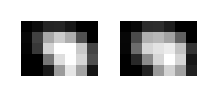

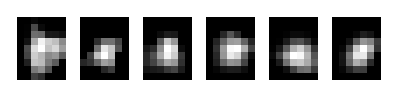

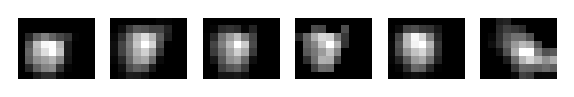

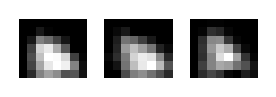

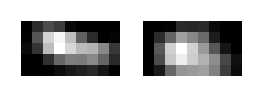

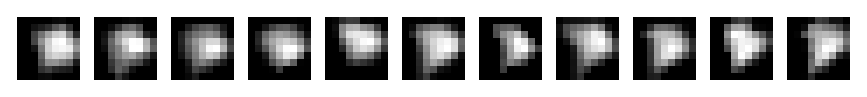

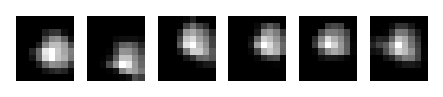

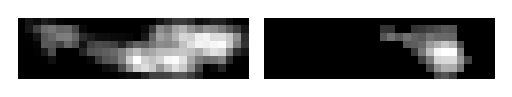

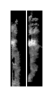

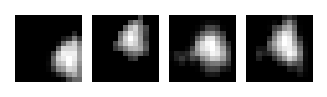

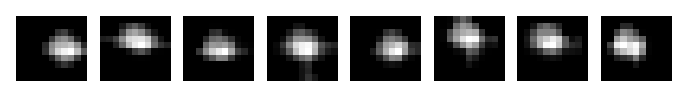

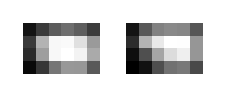

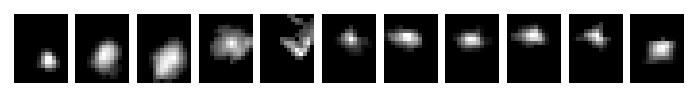

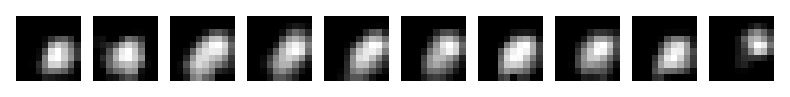

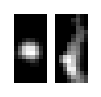

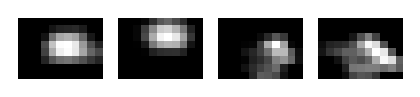

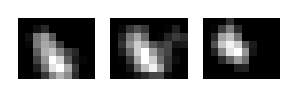

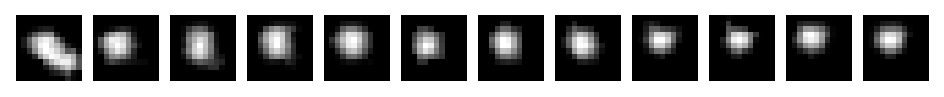

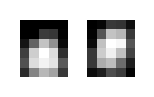

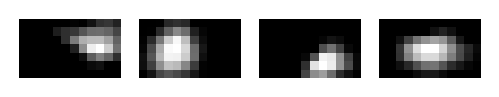

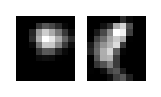

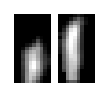

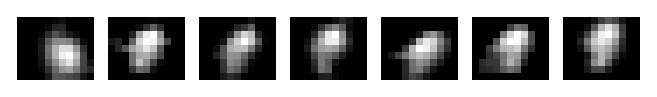

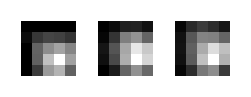

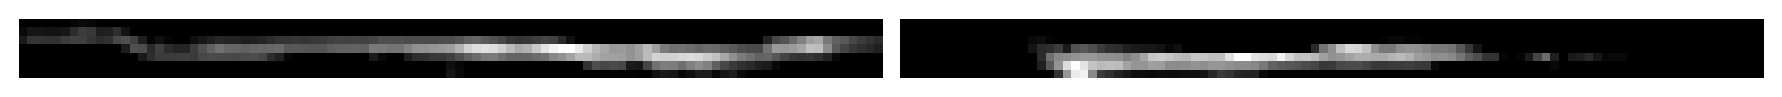

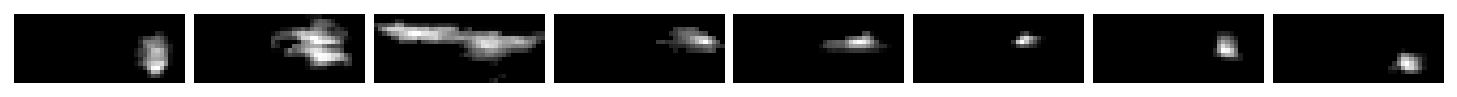

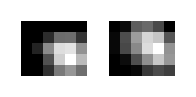

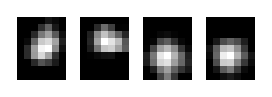

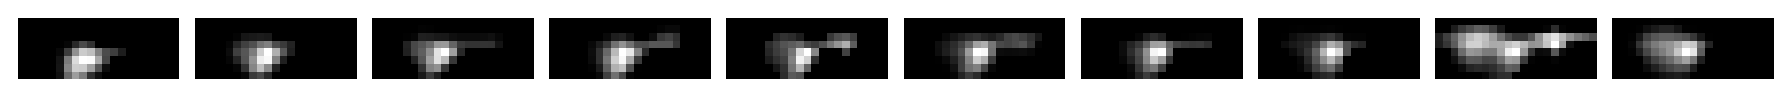

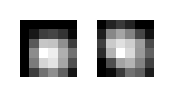

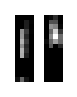

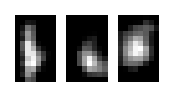

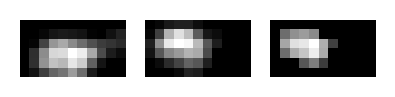

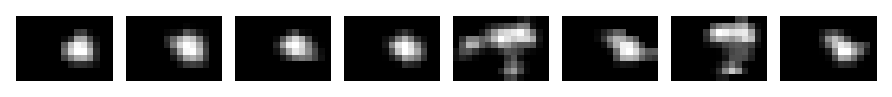

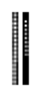

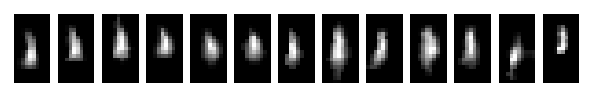

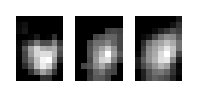

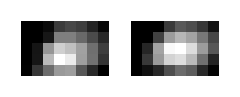

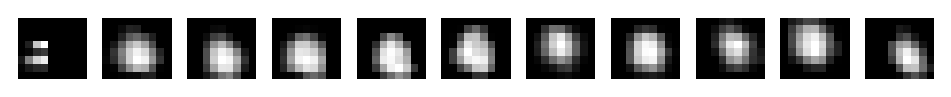

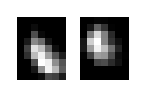

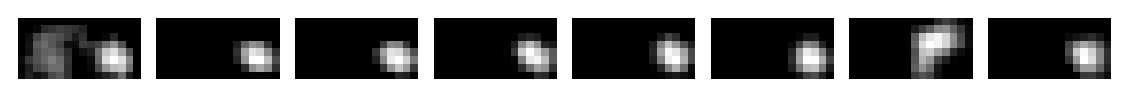

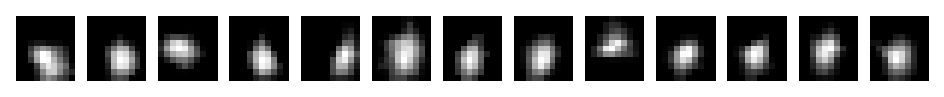

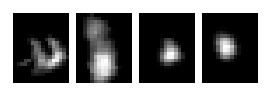

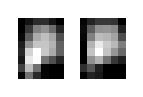

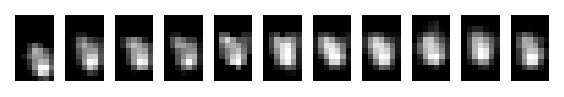

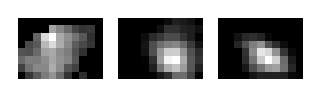

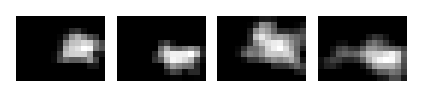

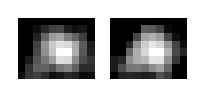

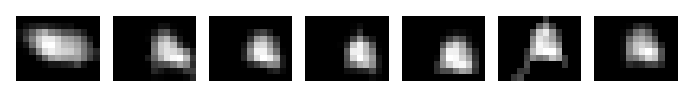

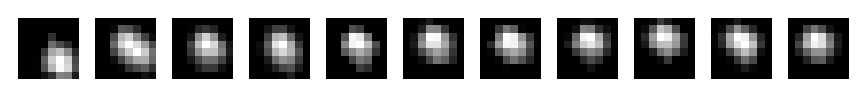

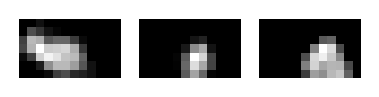

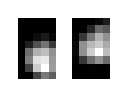

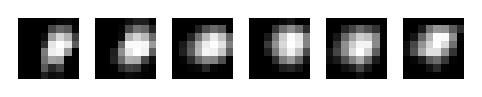

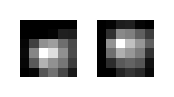

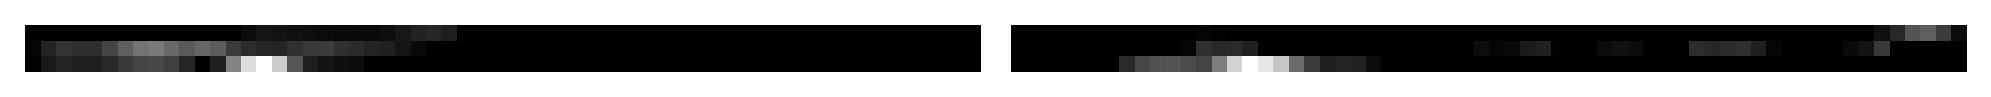

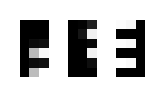

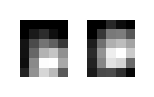

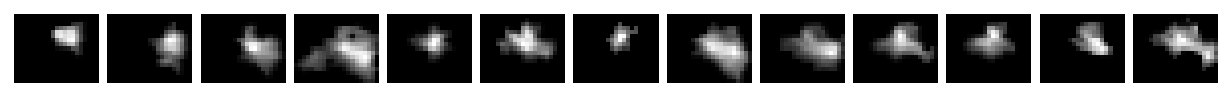

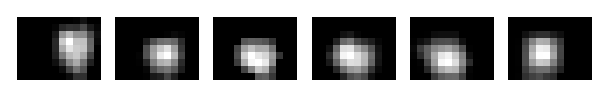

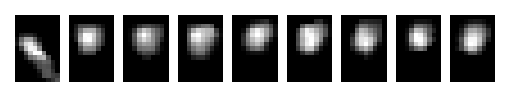

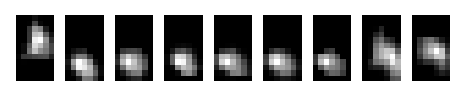

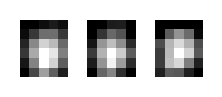

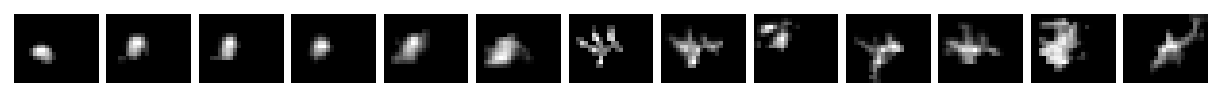

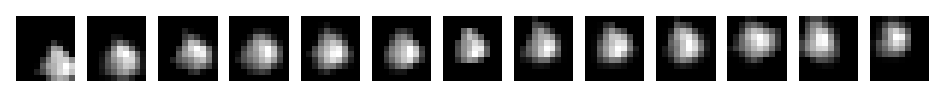

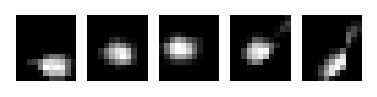

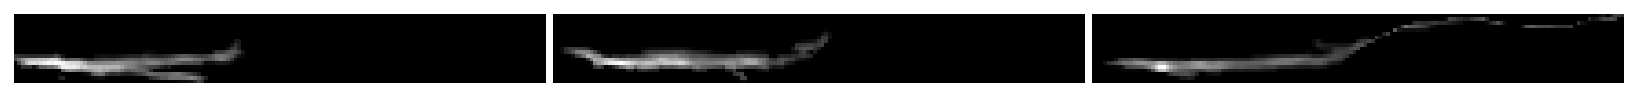

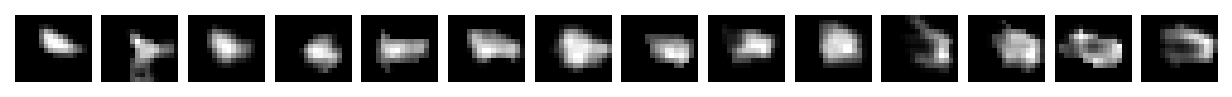

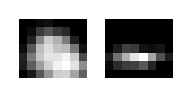

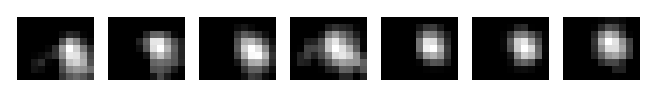

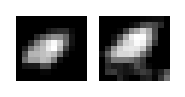

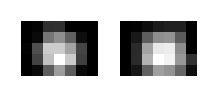

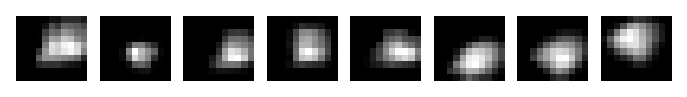

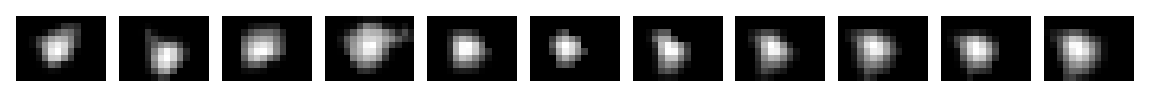

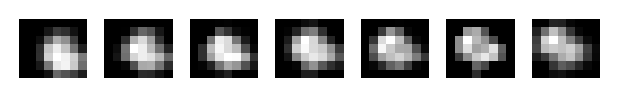

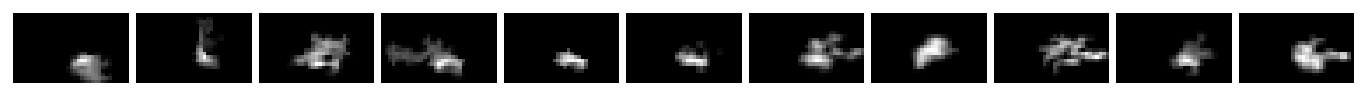

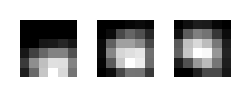

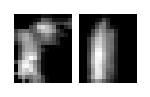

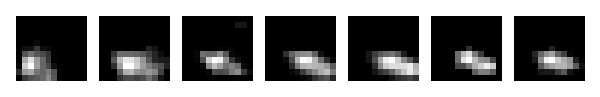

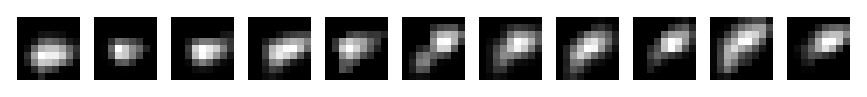

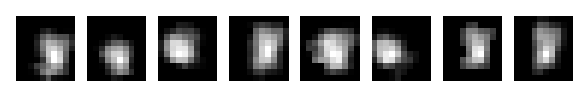

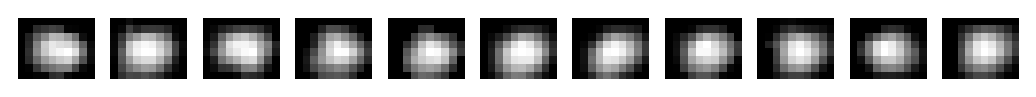

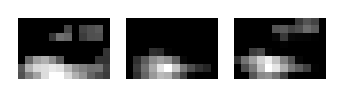

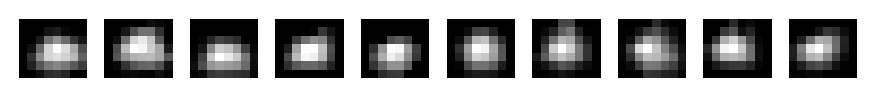

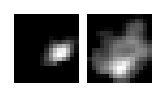

In [38]:
import scipy.sparse

ucids = labels.copy()
# ucids = ucids[ucids==975]
ucids_unique = np.unique(ucids[ucids>-1])

# ROI_ims = np.concatenate(data.ROI_images, axis=0)
ROI_ims_sparse = scipy.sparse.vstack(aligner.ROIs_aligned)
ROI_ims_sparse = ROI_ims_sparse.multiply( ROI_ims_sparse.max(1).power(-1) ).tocsr()


ucid_sfCat = []
for ucid in ucids_unique:
    idx = np.where(ucids == ucid)[0]
    ucid_sfCat.append( np.concatenate(list(roicat.visualization.crop_cluster_ims(ROI_ims_sparse[idx].toarray().reshape(len(idx), data.FOV_height, data.FOV_width))), axis=1) )
#     ucid_sfCat.append( np.concatenate(list(ROI_ims_sparse[idx].toarray().reshape(len(idx), data.FOV_height, data.FOV_width)), axis=1) )
# data.ROI_images[i_sesh][idx] for 


%matplotlib inline

for sf in ucid_sfCat[:100]:
    plt.figure(figsize=(40,1))
    plt.imshow(sf, cmap='gray')
    plt.axis('off')

<IPython.core.display.Javascript object>


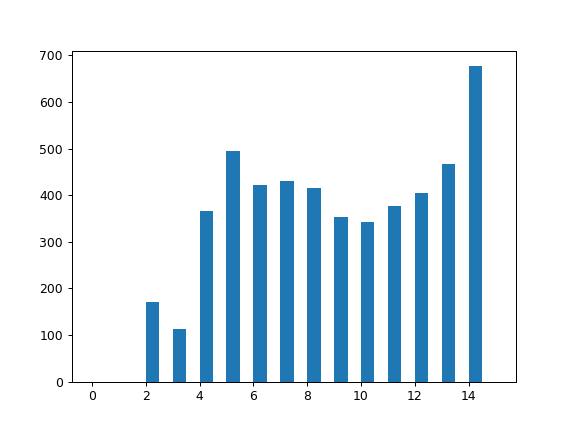

In [63]:
%matplotlib notebook

_, counts = np.unique(labels, return_counts=True)

plt.figure()
plt.hist(counts, 30, range=(0, data.n_sessions+1));


In [40]:
toc['visualize'] = time.time() - tic

# Save results

In [59]:
dir_save = Path('/home/rich/Desktop/').resolve()
# name_save = Path(dir_allOuterFolders).resolve().name
name_save = 'NN9_stringency_0.6'
# path_save = dir_save / (name_save + '.ROICaT.tracking.results' + '.pkl')
path_save = dir_save / (name_save + '.ROICaT.tracking.results' + '.pkl')
print(f'path_save: {path_save}')

path_save: /home/rich/Desktop/NN9_stringency_0.6.ROICaT.tracking.results.pkl


In [60]:
ROIs = {
    "ROIs_aligned": aligner.ROIs_aligned,
    "ROIs_raw": data.spatialFootprints,
    "frame_height": data.FOV_height,
    "frame_width": data.FOV_width,
    "idx_roi_session": np.where(data.sessionID_concat)[1]
}

results = {
    "UCIDs": labels,
    "UCIDs_bySession": labels_bySession,
    "ROIs": ROIs,
    "input_data": {
        "paths_stat": data.paths_stat,
        "paths_ops": data.paths_ops,
    }
}

roicat.helpers.pickle_save(
    obj=results,
    path_save=path_save,
    mkdir=True,
)

In [43]:
toc['saving'] = time.time() - tic

In [44]:
toc

{'start': 3.3855438232421875e-05,
 'import_paths': 1.945674180984497,
 'import_data': 2.01153564453125,
 'alignment': 332.76900458335876,
 'blur': 333.97098422050476,
 'NN': 416.3952693939209,
 'SWT': 418.8033697605133,
 'sim': 703.7691457271576,
 'separate_diffSame': 714.3809337615967,
 'clustering': 1408.5659770965576,
 'visualize': 1633.6610417366028,
 'saving': 1674.019666671753}

Fitting with HDBSCAN and splitting clusters with multiple ROIs per session


100%|█████████████████████████████████████████████| 6/6 [01:44<00:00, 17.37s/it]


Number of clusters: 1293
Number of discarded ROIs: 50895


<IPython.core.display.Javascript object>


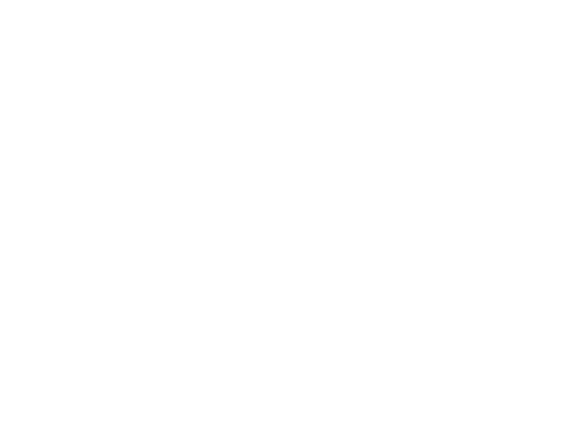

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

/tmp/ipykernel_1628621/2751776504.py:100: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(40,1))


<IPython.core.display.Javascript object>


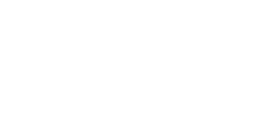

<IPython.core.display.Javascript object>


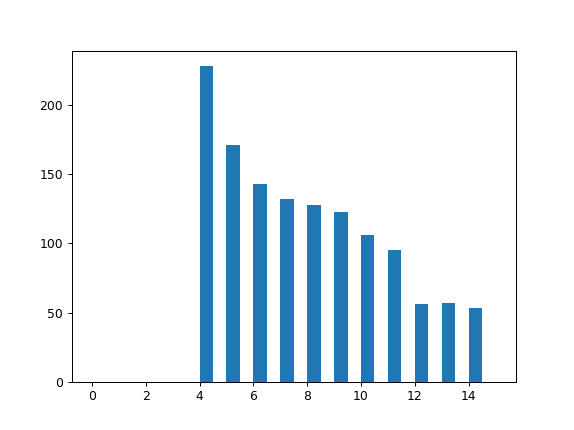

path_save: /home/rich/Desktop/NN9_stringency_0.25.ROICaT.tracking.results.pkl


In [352]:
for s in [0.25]:
    clusterer.make_pruned_similarity_graphs(
        d_cutoff=None,
        kwargs_makeConjunctiveDistanceMatrix=kwargs_makeConjunctiveDistanceMatrix_best,
        stringency=s,
    )

    if data.n_sessions >= 8:
        labels = clusterer.fit(
            session_bool=data.sessionID_concat,
            min_cluster_size=4,
            cluster_selection_method='leaf',
            d_clusterMerge=None,
            alpha=0.999,
            n_iter_violationCorrection=6,
            d_conj=None,
            kwargs_makeConjunctiveDistanceMatrix=kwargs_makeConjunctiveDistanceMatrix_best,
        #     kwargs_makeConjunctiveDistanceMatrix={
        #         'power_SF': 1.0,
        #         'power_NN': 1.0,
        #         'power_SWT': 0.1,
        #         'p_norm': -2,
        #         'sig_SF_kwargs': None,
        #         'sig_NN_kwargs':  {'mu':0, 'b':0.2},
        #         'sig_SWT_kwargs': {'mu':0, 'b':0.2},
        #     },
            split_intraSession_clusters=True,
            discard_failed_pruning=True,
            d_step=0.01,
        )

    else:
        labels = clusterer.fit_sequentialHungarian(
            session_bool=data.sessionID_concat,
            thresh_cost=0.6,
            d_conj=None,
            kwargs_makeConjunctiveDistanceMatrix=kwargs_makeConjunctiveDistanceMatrix_best,
        #     kwargs_makeConjunctiveDistanceMatrix={
        #     'power_SF': 1.0,
        #     'power_NN': 1.0,
        #     'power_SWT': 0.1,
        #     'p_norm': -2,
        #     'sig_SF_kwargs': None,
        #     'sig_NN_kwargs':  {'mu':0, 'b':0.2},
        #     'sig_SWT_kwargs': {'mu':0, 'b':0.2},
        #     },
        )

    labels_bySession = [labels[idx] for idx in data.sessionID_concat.T]

    ## results_clustering
    print(f'Number of clusters: {len(np.unique(labels))}')
    print(f'Number of discarded ROIs: {(labels==-1).sum()}')

    toc['clustering'] = time.time() - tic

    # Visualize results

    FOV_clusters = roicat.visualization.compute_colored_FOV(
        spatialFootprints=[r.power(0.7) for r in aligner.ROIs_aligned],
        FOV_height=data.FOV_height,
        FOV_width=data.FOV_width,
        boolSessionID=data.sessionID_concat,
        labels=labels,
        confidence=None,
    )

    %matplotlib notebook
    roicat.visualization.display_toggle_image_stack(
        FOV_clusters, 
    #     interpolation='none', 
    #     filternorm=False, 
    #     resample=False
    )

    # visualization.display_toggle_image_stack(aligner.get_ROIsAligned_maxIntensityProjection())

    import scipy.sparse

    ucids = labels.copy()
    # ucids = ucids[ucids==975]
    ucids_unique = np.unique(ucids[ucids>-1])

    # ROI_ims = np.concatenate(data.ROI_images, axis=0)
    ROI_ims_sparse = scipy.sparse.vstack(aligner.ROIs_aligned)
    ROI_ims_sparse = ROI_ims_sparse.multiply( ROI_ims_sparse.max(1).power(-1) ).tocsr()


    ucid_sfCat = []
    for ucid in ucids_unique:
        idx = np.where(ucids == ucid)[0]
        ucid_sfCat.append( np.concatenate(list(roicat.visualization.crop_cluster_ims(ROI_ims_sparse[idx].toarray().reshape(len(idx), data.FOV_height, data.FOV_width))), axis=1) )
    #     ucid_sfCat.append( np.concatenate(list(ROI_ims_sparse[idx].toarray().reshape(len(idx), data.FOV_height, data.FOV_width)), axis=1) )
    # data.ROI_images[i_sesh][idx] for 


    %matplotlib inline

    for sf in ucid_sfCat[:100]:
        plt.figure(figsize=(40,1))
        plt.imshow(sf, cmap='gray')
        plt.axis('off')

    %matplotlib notebook

    _, counts = np.unique(labels, return_counts=True)

    plt.figure()
    plt.hist(counts, 30, range=(0, data.n_sessions+1));


    %matplotlib notebook

    _, counts = np.unique(labels, return_counts=True)

    plt.figure()
    plt.hist(counts, 30, range=(0, data.n_sessions+1));


    toc['visualize'] = time.time() - tic

    # Save results

    dir_save = Path('/home/rich/Desktop/').resolve()
    # name_save = Path(dir_allOuterFolders).resolve().name
    name_save = f'NN9_stringency_{s}'
    # path_save = dir_save / (name_save + '.ROICaT.tracking.results' + '.pkl')
    path_save = dir_save / (name_save + '.ROICaT.tracking.results' + '.pkl')
    print(f'path_save: {path_save}')

    ROIs = {
        "ROIs_aligned": aligner.ROIs_aligned,
        "ROIs_raw": data.spatialFootprints,
        "frame_height": data.FOV_height,
        "frame_width": data.FOV_width,
        "idx_roi_session": np.where(data.sessionID_concat)[1]
    }

    results = {
        "UCIDs": labels,
        "UCIDs_bySession": labels_bySession,
        "ROIs": ROIs,
        "input_data": {
            "paths_stat": data.paths_stat,
            "paths_ops": data.paths_ops,
        }
    }

    roicat.helpers.pickle_save(
        obj=results,
        path_save=path_save,
        mkdir=True,
    )

    toc['saving'] = time.time() - tic

    toc